In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
#pip install torch


In [4]:
df = pd.read_csv("dataset.csv")
df.head()

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [5]:
enc = OneHotEncoder(drop='first', handle_unknown='ignore')
enc.fit(df[["f1", "f2", "f3", "f4", "f5"]])
categorical = enc.transform(df[["f1", "f2", "f3", "f4", "f5"]]).toarray()
categorical

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [6]:
df.f6 = df.f6.apply(lambda x: "0" if x == "d" else x)
df.f7 = df.f7.apply(lambda x: "0" if x == "e" else x)

In [7]:
df.f1

0       6
1       1
2       8
3       1
4       0
       ..
761     9
762    10
763     2
764     c
765     1
Name: f1, Length: 766, dtype: object

In [8]:
scaler = StandardScaler()
scaler.fit(df[["f6", "f7"]])
numerical = scaler.transform(df[["f6", "f7"]])

In [9]:
df.f6

0      33.6
1      26.6
2      23.3
3      28.1
4      43.1
       ... 
761    22.5
762       0
763    36.8
764    26.2
765    30.1
Name: f6, Length: 766, dtype: object

In [10]:
X = np.concatenate([categorical, numerical], axis=1)
y = df.target.values

In [11]:
y


array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [14]:
train_dataset = Dataset(X_train, y_train)
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=0,
    pin_memory=False,
    shuffle=True,
)

test_dataset = Dataset(X_test, y_test)
test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    num_workers=0,
    pin_memory=False,
    shuffle=False,
)

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [16]:
def save_checkpoint(model, optimizer, filename="model.pth.tar"):
    print("=>Saving Checkpoint...")
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_path, model, optimizer):
    print("=>Loading Checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [17]:
def train(train_data_loader, model, bce, optimizer, epoch):
    model.train()
    losses = []

    train_progress_bar = tqdm(enumerate(train_data_loader), total=len(train_data_loader), leave=False)
    for batch_idx, (X, y) in train_progress_bar:
        X = X.to(DEVICE)
        y = y.unsqueeze(1).to(DEVICE)
        outputs = model(X)
        loss = bce(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_progress_bar.set_description(f"Epoch [{epoch}/{epochs-1}]")
        train_progress_bar.set_postfix(train_loss=loss.item())
        losses.append(loss.item())
        
    train_progress_bar.close()
    return sum(losses) / len(losses)

In [18]:
def evaluate(test_data_loader, model):
    model.eval()
    predictions = []
    targets = []

    for X, y in tqdm(test_data_loader):
        X = X.to(device=DEVICE)
        y = y.to(DEVICE)

        with torch.no_grad():
            outputs = model(X)

        predictions.append(torch.sigmoid(outputs).detach().cpu())
        targets.append(y.detach().cpu())

    predictions = torch.cat(predictions, dim=0).view(-1).numpy()
    targets = torch.cat(targets, dim=0).view(-1).numpy()

    accuracy = metrics.accuracy_score(targets, predictions > 0.5)
    return accuracy

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOAD_MODEL = False
learning_rate = 0.009
epochs = 100

model = NeuralNetwork(in_features=X_train.shape[1]).to(DEVICE)
bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

if LOAD_MODEL: 
    load_checkpoint(f"model.pth.tar", model, optimizer)

losses = []
acc = -float("inf")
for epoch in range(epochs):
    loss = train(train_data_loader, model, bce, optimizer, epoch)
    test_accuracy = evaluate(test_data_loader, model)
    train_accuracy = evaluate(train_data_loader, model)

    if test_accuracy > acc:
        save_checkpoint(model, optimizer, filename=f"model.pth.tar")
        acc = test_accuracy
    print(f"Epoch: {epoch}, Loss: {loss}, train_accuracy: {train_accuracy}, test_accuracy: {test_accuracy}")
    losses.append(loss)

100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2239.69it/s]


=>Saving Checkpoint...
Epoch: 0, Loss: 0.6444782790465232, train_accuracy: 0.6503267973856209, test_accuracy: 0.6493506493506493


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3145.91it/s]


Epoch: 1, Loss: 0.6308793952831855, train_accuracy: 0.6503267973856209, test_accuracy: 0.6493506493506493


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3197.50it/s]


Epoch: 2, Loss: 0.5882705893272009, train_accuracy: 0.7189542483660131, test_accuracy: 0.6493506493506493


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3627.24it/s]


Epoch: 3, Loss: 0.5821444690227509, train_accuracy: 0.7565359477124183, test_accuracy: 0.6363636363636364


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3048.07it/s]


Epoch: 4, Loss: 0.593010290310933, train_accuracy: 0.7679738562091504, test_accuracy: 0.6363636363636364


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3743.20it/s]


Epoch: 5, Loss: 0.581298984778233, train_accuracy: 0.7418300653594772, test_accuracy: 0.6493506493506493


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2993.52it/s]


=>Saving Checkpoint...
Epoch: 6, Loss: 0.5539293740040216, train_accuracy: 0.8186274509803921, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3133.80it/s]


=>Saving Checkpoint...
Epoch: 7, Loss: 0.5344749222963284, train_accuracy: 0.8382352941176471, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2398.26it/s]


Epoch: 8, Loss: 0.5095695165487436, train_accuracy: 0.8496732026143791, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3029.78it/s]


=>Saving Checkpoint...
Epoch: 9, Loss: 0.4880106166387216, train_accuracy: 0.8627450980392157, test_accuracy: 0.7142857142857143


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2588.99it/s]


Epoch: 10, Loss: 0.4484957777536832, train_accuracy: 0.880718954248366, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3300.80it/s]


Epoch: 11, Loss: 0.41849326839049655, train_accuracy: 0.8774509803921569, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3020.16it/s]


Epoch: 12, Loss: 0.46709777070925784, train_accuracy: 0.8839869281045751, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3176.64it/s]


Epoch: 13, Loss: 0.4476960347248958, train_accuracy: 0.8905228758169934, test_accuracy: 0.7142857142857143


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3696.67it/s]


Epoch: 14, Loss: 0.40946092150914365, train_accuracy: 0.8970588235294118, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3768.12it/s]


Epoch: 15, Loss: 0.39136877732399183, train_accuracy: 0.9019607843137255, test_accuracy: 0.6948051948051948


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3316.06it/s]


Epoch: 16, Loss: 0.3868606159320244, train_accuracy: 0.9117647058823529, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3353.72it/s]


Epoch: 17, Loss: 0.4201332468252916, train_accuracy: 0.9133986928104575, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3219.72it/s]


Epoch: 18, Loss: 0.32315607292529863, train_accuracy: 0.9084967320261438, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3288.06it/s]


Epoch: 19, Loss: 0.36081765592098236, train_accuracy: 0.923202614379085, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3403.48it/s]


Epoch: 20, Loss: 0.38387191142791355, train_accuracy: 0.9248366013071896, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3306.54it/s]


Epoch: 21, Loss: 0.37159300232544923, train_accuracy: 0.9297385620915033, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3076.91it/s]


Epoch: 22, Loss: 0.30009184777736664, train_accuracy: 0.9330065359477124, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3321.98it/s]


Epoch: 23, Loss: 0.3318351967594562, train_accuracy: 0.9313725490196079, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2947.61it/s]


=>Saving Checkpoint...
Epoch: 24, Loss: 0.31316361480798477, train_accuracy: 0.9395424836601307, test_accuracy: 0.7207792207792207


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2851.88it/s]


Epoch: 25, Loss: 0.31435717680515385, train_accuracy: 0.9395424836601307, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3671.29it/s]


Epoch: 26, Loss: 0.2778303740689388, train_accuracy: 0.9411764705882353, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2915.67it/s]


Epoch: 27, Loss: 0.2678683801339223, train_accuracy: 0.9428104575163399, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3267.70it/s]


Epoch: 28, Loss: 0.2727032066919865, train_accuracy: 0.9477124183006536, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2765.57it/s]


Epoch: 29, Loss: 0.29670819582847446, train_accuracy: 0.9477124183006536, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3351.73it/s]


Epoch: 30, Loss: 0.2773410372245006, train_accuracy: 0.9526143790849673, test_accuracy: 0.7142857142857143


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2928.35it/s]


Epoch: 31, Loss: 0.28720049407237613, train_accuracy: 0.9526143790849673, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3393.94it/s]


Epoch: 32, Loss: 0.26563944476537216, train_accuracy: 0.9558823529411765, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2531.66it/s]


Epoch: 33, Loss: 0.23235368900574171, train_accuracy: 0.9591503267973857, test_accuracy: 0.6948051948051948


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3420.99it/s]


Epoch: 34, Loss: 0.31587928743698657, train_accuracy: 0.9575163398692811, test_accuracy: 0.7207792207792207


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2864.01it/s]


Epoch: 35, Loss: 0.24906004078160876, train_accuracy: 0.9591503267973857, test_accuracy: 0.7207792207792207


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3123.98it/s]


Epoch: 36, Loss: 0.2230872023755159, train_accuracy: 0.9640522875816994, test_accuracy: 0.7142857142857143


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3172.51it/s]


Epoch: 37, Loss: 0.23130022581571189, train_accuracy: 0.9656862745098039, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2709.23it/s]


Epoch: 38, Loss: 0.22242351096027937, train_accuracy: 0.9689542483660131, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3012.76it/s]


Epoch: 39, Loss: 0.22928522680050287, train_accuracy: 0.9722222222222222, test_accuracy: 0.7207792207792207


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2806.61it/s]


Epoch: 40, Loss: 0.19412836766777894, train_accuracy: 0.9722222222222222, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3322.25it/s]


Epoch: 41, Loss: 0.218386354832313, train_accuracy: 0.9722222222222222, test_accuracy: 0.6948051948051948


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2583.96it/s]


Epoch: 42, Loss: 0.21071232394434702, train_accuracy: 0.9722222222222222, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2722.71it/s]


Epoch: 43, Loss: 0.21517938241744652, train_accuracy: 0.9738562091503268, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2932.50it/s]


Epoch: 44, Loss: 0.2549512310861013, train_accuracy: 0.9771241830065359, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3015.32it/s]


Epoch: 45, Loss: 0.21447657144222504, train_accuracy: 0.9820261437908496, test_accuracy: 0.7077922077922078


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2589.32it/s]


Epoch: 46, Loss: 0.24400051549459115, train_accuracy: 0.9836601307189542, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3262.81it/s]


Epoch: 47, Loss: 0.1989612672955562, train_accuracy: 0.9836601307189542, test_accuracy: 0.6948051948051948


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2629.62it/s]


Epoch: 48, Loss: 0.23293472635440338, train_accuracy: 0.9820261437908496, test_accuracy: 0.7142857142857143


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2879.54it/s]


Epoch: 49, Loss: 0.2396039004700306, train_accuracy: 0.9852941176470589, test_accuracy: 0.6818181818181818


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1641.28it/s]


Epoch: 50, Loss: 0.1857155982303457, train_accuracy: 0.9820261437908496, test_accuracy: 0.6948051948051948


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3154.04it/s]


Epoch: 51, Loss: 0.1862174579157279, train_accuracy: 0.9836601307189542, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2774.43it/s]


Epoch: 52, Loss: 0.18797480162137595, train_accuracy: 0.9869281045751634, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2372.41it/s]


Epoch: 53, Loss: 0.19889891711183083, train_accuracy: 0.988562091503268, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1607.85it/s]


Epoch: 54, Loss: 0.20149538804514286, train_accuracy: 0.9901960784313726, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3484.09it/s]


Epoch: 55, Loss: 0.16414633065160628, train_accuracy: 0.9901960784313726, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2508.36it/s]


Epoch: 56, Loss: 0.18499423214831415, train_accuracy: 0.9901960784313726, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3476.61it/s]


Epoch: 57, Loss: 0.18818891459168532, train_accuracy: 0.988562091503268, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3183.63it/s]


Epoch: 58, Loss: 0.19854609706462958, train_accuracy: 0.9852941176470589, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2582.94it/s]


Epoch: 59, Loss: 0.18116749092363393, train_accuracy: 0.9852941176470589, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3599.07it/s]


Epoch: 60, Loss: 0.16852239864424634, train_accuracy: 0.9934640522875817, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3108.01it/s]


Epoch: 61, Loss: 0.18012176377651018, train_accuracy: 0.9934640522875817, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2632.11it/s]


Epoch: 62, Loss: 0.16964213122637609, train_accuracy: 0.9934640522875817, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2883.29it/s]


Epoch: 63, Loss: 0.18385326069517013, train_accuracy: 0.9934640522875817, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3933.11it/s]


Epoch: 64, Loss: 0.16493034159812409, train_accuracy: 0.988562091503268, test_accuracy: 0.6493506493506493


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3573.44it/s]


Epoch: 65, Loss: 0.17784561804280832, train_accuracy: 0.9869281045751634, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3329.63it/s]


Epoch: 66, Loss: 0.1654124744863321, train_accuracy: 0.9901960784313726, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3542.26it/s]


Epoch: 67, Loss: 0.20801058946511683, train_accuracy: 0.9901960784313726, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3563.55it/s]


Epoch: 68, Loss: 0.15330771194436613, train_accuracy: 0.9918300653594772, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3824.68it/s]


Epoch: 69, Loss: 0.166730677287351, train_accuracy: 0.9918300653594772, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3671.53it/s]


Epoch: 70, Loss: 0.18559909019714746, train_accuracy: 0.9918300653594772, test_accuracy: 0.6818181818181818


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3055.70it/s]


Epoch: 71, Loss: 0.15664253142686227, train_accuracy: 0.9901960784313726, test_accuracy: 0.6948051948051948


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2979.67it/s]


Epoch: 72, Loss: 0.17624848874178356, train_accuracy: 0.9901960784313726, test_accuracy: 0.7012987012987013


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3075.64it/s]


Epoch: 73, Loss: 0.1787996675628118, train_accuracy: 0.9918300653594772, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3058.56it/s]


Epoch: 74, Loss: 0.17497466714718404, train_accuracy: 0.9918300653594772, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2949.69it/s]


Epoch: 75, Loss: 0.16712629742538318, train_accuracy: 0.9918300653594772, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3334.10it/s]


Epoch: 76, Loss: 0.1370063172892118, train_accuracy: 0.9918300653594772, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3804.14it/s]


Epoch: 77, Loss: 0.1620916971602501, train_accuracy: 0.9901960784313726, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3398.67it/s]


Epoch: 78, Loss: 0.13193431020511362, train_accuracy: 0.9901960784313726, test_accuracy: 0.6948051948051948


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2919.21it/s]


Epoch: 79, Loss: 0.16398881509518012, train_accuracy: 0.9934640522875817, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3457.06it/s]


Epoch: 80, Loss: 0.15022229480867585, train_accuracy: 0.9918300653594772, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3462.70it/s]


Epoch: 81, Loss: 0.14127896234202078, train_accuracy: 0.9918300653594772, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3076.16it/s]


Epoch: 82, Loss: 0.1486229996364086, train_accuracy: 0.988562091503268, test_accuracy: 0.6818181818181818


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2390.86it/s]


Epoch: 83, Loss: 0.1544342240652977, train_accuracy: 0.988562091503268, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3261.97it/s]


Epoch: 84, Loss: 0.16005063708314246, train_accuracy: 0.9918300653594772, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2975.77it/s]


Epoch: 85, Loss: 0.15915050519964632, train_accuracy: 0.9901960784313726, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3335.60it/s]


Epoch: 86, Loss: 0.17114205786194175, train_accuracy: 0.988562091503268, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2290.36it/s]


Epoch: 87, Loss: 0.15362091101885128, train_accuracy: 0.9901960784313726, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3266.59it/s]


Epoch: 88, Loss: 0.14605781765511403, train_accuracy: 0.9918300653594772, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3199.63it/s]


Epoch: 89, Loss: 0.15535115173611885, train_accuracy: 0.9950980392156863, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3389.86it/s]


Epoch: 90, Loss: 0.14974367284239867, train_accuracy: 0.9950980392156863, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3492.42it/s]


Epoch: 91, Loss: 0.13890770077705347, train_accuracy: 0.9950980392156863, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3671.95it/s]


Epoch: 92, Loss: 0.13576160891888997, train_accuracy: 0.9950980392156863, test_accuracy: 0.6623376623376623


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3238.65it/s]


Epoch: 93, Loss: 0.16186661819213044, train_accuracy: 0.9950980392156863, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3252.69it/s]


Epoch: 94, Loss: 0.1480863111971233, train_accuracy: 0.9950980392156863, test_accuracy: 0.6883116883116883


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3287.01it/s]


Epoch: 95, Loss: 0.146128282094231, train_accuracy: 0.9950980392156863, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3190.39it/s]


Epoch: 96, Loss: 0.16335062068910935, train_accuracy: 0.9934640522875817, test_accuracy: 0.6753246753246753


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2865.51it/s]


Epoch: 97, Loss: 0.1284003639832521, train_accuracy: 0.9950980392156863, test_accuracy: 0.6818181818181818


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3070.85it/s]


Epoch: 98, Loss: 0.14386188737355554, train_accuracy: 0.9934640522875817, test_accuracy: 0.6688311688311688


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 3599.47it/s]

Epoch: 99, Loss: 0.16815213440401214, train_accuracy: 0.9918300653594772, test_accuracy: 0.6883116883116883


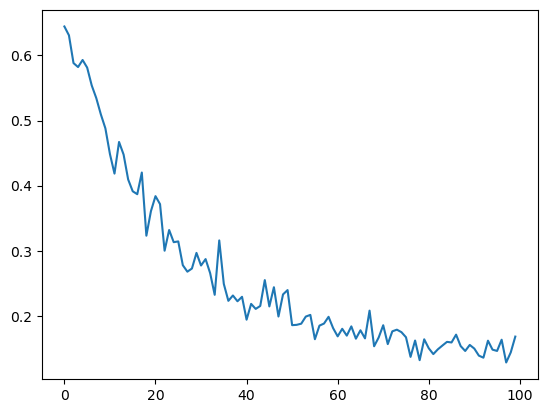

In [20]:
plt.plot(losses)

In [21]:
print("accuracy is: ", acc)

accuracy is:  0.7207792207792207


In [22]:
def predict(test_data_loader, model):
    model.eval()
    predictions = []
    targets = []

    for X, y in tqdm(test_data_loader):
        X = X.to(device=DEVICE)
        y = y.to(DEVICE)

        with torch.no_grad():
            outputs = model(X)

        predictions.append(torch.sigmoid(outputs).detach().cpu())
        targets.append(y.detach().cpu())

    predictions = torch.cat(predictions, dim=0).view(-1).numpy()
    targets = torch.cat(targets, dim=0).view(-1).numpy()

    return predictions, targets

In [23]:
load_checkpoint(f"model.pth.tar", model, optimizer)
accuracy = evaluate(test_data_loader, model)
predictions, targets = predict(test_data_loader, model)

=>Loading Checkpoint...


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2389.51it/s]


<AxesSubplot:>

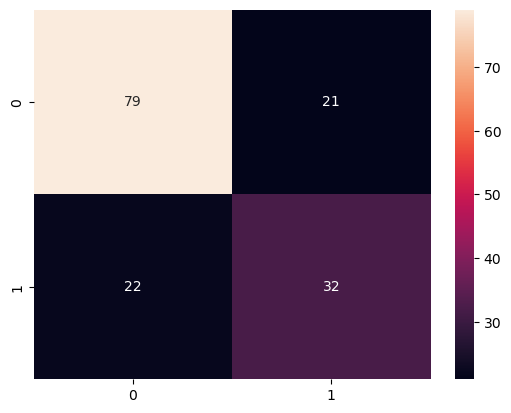

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(targets, predictions > 0.5)
sns.heatmap(cm, annot=True)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(targets, predictions > 0.5))

              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79       100
         1.0       0.60      0.59      0.60        54

    accuracy                           0.72       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.72      0.72       154



In [26]:
print("accuracy is: ", accuracy)

accuracy is:  0.7207792207792207


In [27]:
class NeuralNetwork_new(nn.Module):
    def __init__(self, in_features, dropout=0.5, act="relu"):
        super().__init__()
        self.layer1 = nn.Linear(in_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        if act == "relu":
            self.act = nn.ReLU()
        elif act == "sigmoid":
            self.act = nn.Sigmoid()
        elif act == "tanh":
            self.act = nn.Tanh()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)
        return x

In [28]:
def train(train_data_loader, model, bce, optimizer, epoch):
    model.train()
    losses = []

    train_progress_bar = tqdm(enumerate(train_data_loader), total=len(train_data_loader), leave=False)
    for batch_idx, (X, y) in train_progress_bar:
        X = X.to(DEVICE)
        y = y.unsqueeze(1).to(DEVICE)
        outputs = model(X)
        loss = bce(outputs, y) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_progress_bar.set_description(f"Epoch [{epoch}/{epochs-1}]")
        train_progress_bar.set_postfix(train_loss=loss.item())
        losses.append(loss.item())
        
    train_progress_bar.close()
    return sum(losses) / len(losses)

In [29]:
def evaluate(test_data_loader, model, bce):
    model.eval()
    losses = []
    predictions = []
    targets = []

    for X, y in tqdm(test_data_loader):
        X = X.to(device=DEVICE)
        y = y.to(DEVICE)

        with torch.no_grad():
            outputs = model(X)
            loss = bce(outputs, y.unsqueeze(1))
            losses.append(loss.item())

        predictions.append(torch.sigmoid(outputs).detach().cpu())
        targets.append(y.detach().cpu())

    predictions = torch.cat(predictions, dim=0).view(-1).numpy()
    targets = torch.cat(targets, dim=0).view(-1).numpy()

    accuracy = metrics.accuracy_score(targets, predictions > 0.5)
    return sum(losses)/len(losses), accuracy

In [30]:
def save_checkpoint(model, optimizer, filename="model.pth.tar"):
    print("=>Saving Checkpoint...")
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_path, model, optimizer):
    print("=>Loading Checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [31]:
def get_smooth(arr):
    res = []
    s = 0
    for ind, ele in enumerate(arr):
        s += ele
        res.append(s/(ind+1))
    return res

In [32]:
def run(model, bce, optimizer, epochs=20):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    acc = -float("inf")
    for epoch in range(epochs):
        train_loss = train(train_data_loader, model, bce, optimizer, epoch)
        _, train_accuracy = evaluate(train_data_loader, model, bce)
        test_loss, test_accuracy = evaluate(test_data_loader, model, bce)

        if test_accuracy > acc:
            save_checkpoint(model, optimizer, filename=f"model.pth.tar")
            acc = test_accuracy

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch: {epoch}, Loss: {train_loss}, train_accuracy: {train_accuracy}, test_accuracy: {test_accuracy}")
    return train_losses, test_losses, train_accuracies, test_accuracies, acc

In [33]:
%%capture
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

model1 = NeuralNetwork_new(in_features=X_train.shape[1], dropout=0.1).to(DEVICE)
model2 = NeuralNetwork_new(in_features=X_train.shape[1], dropout=0.5).to(DEVICE)
model3 = NeuralNetwork_new(in_features=X_train.shape[1], dropout=1).to(DEVICE)

train_losses1, test_losses1, train_accuracies1, test_accuracies1, acc1 = run(model1, bce, optimizer)
train_losses2, test_losses2, train_accuracies2, test_accuracies2, acc2 = run(model2, bce, optimizer)
train_losses3, test_losses3, train_accuracies3, test_accuracies3, acc3 = run(model3, bce, optimizer)

Accuracy0.1 is:  0.6233766233766234


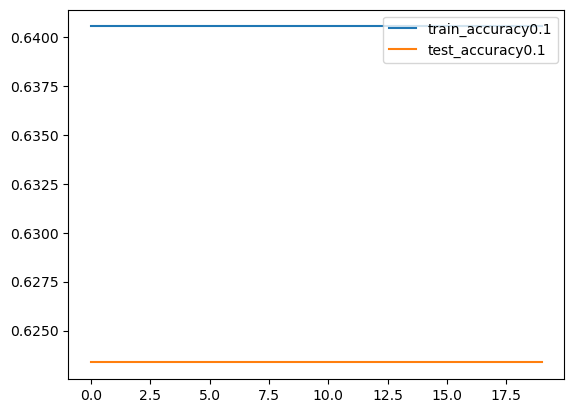

In [34]:
plt.plot(range(epochs), get_smooth(train_accuracies1), label='train_accuracy0.1')
plt.plot(range(epochs), get_smooth(test_accuracies1), label='test_accuracy0.1')
plt.legend(loc='upper right')
print("Accuracy0.1 is: ", acc1)

Accuracy0.5 is:  0.35064935064935066


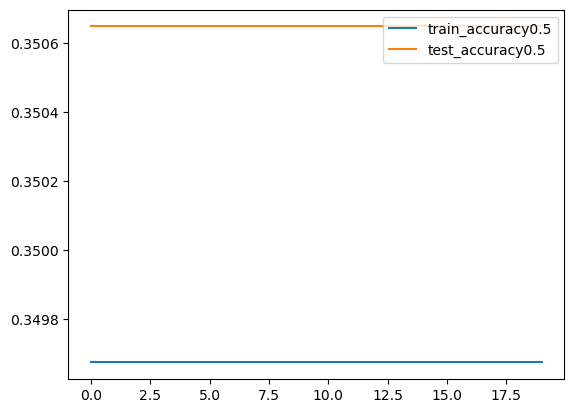

In [35]:
plt.plot(range(epochs), get_smooth(train_accuracies2), label='train_accuracy0.5')
plt.plot(range(epochs), get_smooth(test_accuracies2), label='test_accuracy0.5')
plt.legend(loc='upper right')
print("Accuracy0.5 is: ", acc2)

Accuracy1 is:  0.35064935064935066


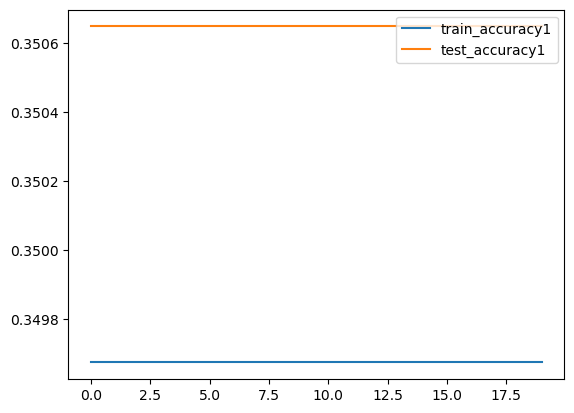

In [36]:
plt.plot(range(epochs), get_smooth(train_accuracies3), label='train_accuracy1')
plt.plot(range(epochs), get_smooth(test_accuracies3), label='test_accuracy1')
plt.legend(loc='upper right')
print("Accuracy1 is: ", acc3)

In [37]:
%%capture
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

model1 = NeuralNetwork_new(in_features=X_train.shape[1], act="relu").to(DEVICE)
model2 = NeuralNetwork_new(in_features=X_train.shape[1], act="sigmoid").to(DEVICE)
model3 = NeuralNetwork_new(in_features=X_train.shape[1], act="tanh").to(DEVICE)

train_losses1, test_losses1, train_accuracies1, test_accuracies1, acc1 = run(model1, bce, optimizer)
train_losses2, test_losses2, train_accuracies2, test_accuracies2, acc2 = run(model2, bce, optimizer)
train_losses3, test_losses3, train_accuracies3, test_accuracies3, acc3 = run(model3, bce, optimizer)

Accuracy relu is:  0.35064935064935066


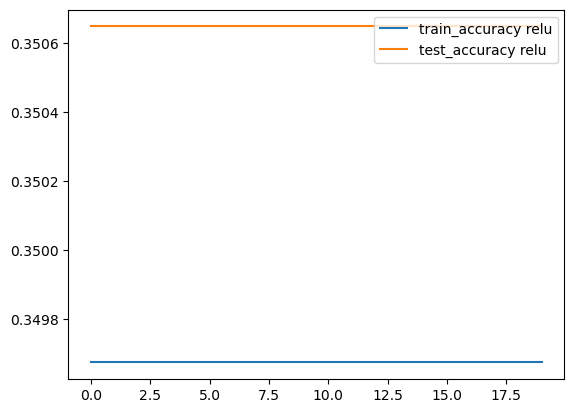

In [38]:
plt.plot(range(epochs), get_smooth(train_accuracies1), label='train_accuracy relu')
plt.plot(range(epochs), get_smooth(test_accuracies1), label='test_accuracy relu')
plt.legend(loc='upper right')
print("Accuracy relu is: ", acc1)

Accuracy sigmoid is:  0.35064935064935066


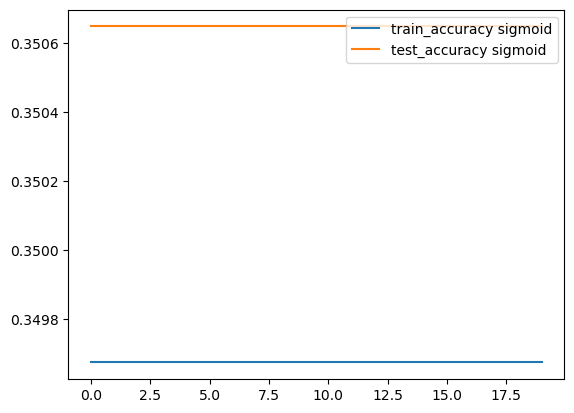

In [39]:
plt.plot(range(epochs), get_smooth(train_accuracies2), label='train_accuracy sigmoid')
plt.plot(range(epochs), get_smooth(test_accuracies2), label='test_accuracy sigmoid')
plt.legend(loc='upper right')
print("Accuracy sigmoid is: ", acc2)

Accuracy tanh is:  0.6493506493506493


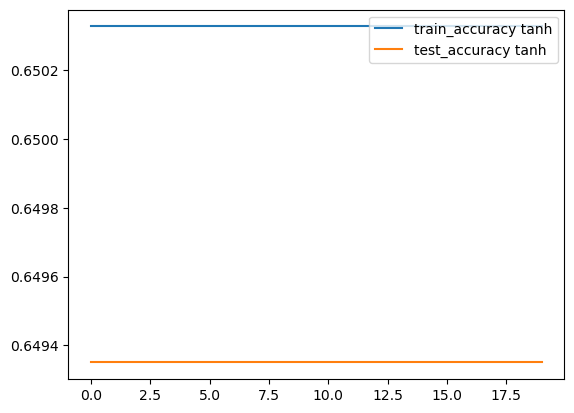

In [40]:
plt.plot(range(epochs), get_smooth(train_accuracies3), label='train_accuracy tanh')
plt.plot(range(epochs), get_smooth(test_accuracies3), label='test_accuracy tanh')
plt.legend(loc='upper right')
print("Accuracy tanh is: ", acc3)

In [41]:
%%capture
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
bce = nn.BCEWithLogitsLoss()
model = NeuralNetwork_new(in_features=X_train.shape[1], act="relu").to(DEVICE)

optimizer1 = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
optimizer2 = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
optimizer3 = optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.001)

train_losses1, test_losses1, train_accuracies1, test_accuracies1, acc1 = run(model, bce, optimizer1)
train_losses2, test_losses2, train_accuracies2, test_accuracies2, acc2 = run(model, bce, optimizer2)
train_losses3, test_losses3, train_accuracies3, test_accuracies3, acc3 = run(model, bce, optimizer3)

Accuracy adam is:  0.7012987012987013


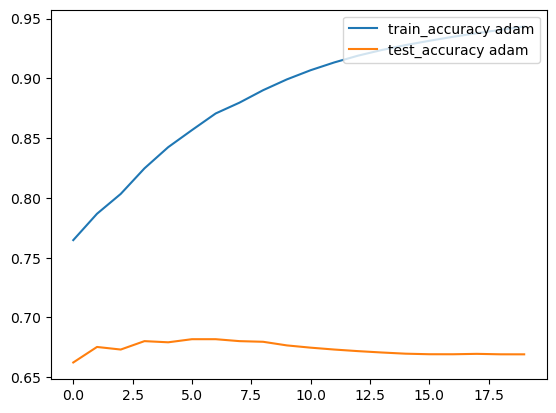

In [42]:
plt.plot(range(epochs), get_smooth(train_accuracies1), label='train_accuracy adam')
plt.plot(range(epochs), get_smooth(test_accuracies1), label='test_accuracy adam')
plt.legend(loc='upper right')
print("Accuracy adam is: ", acc1)

Accuracy sgd is:  0.6818181818181818


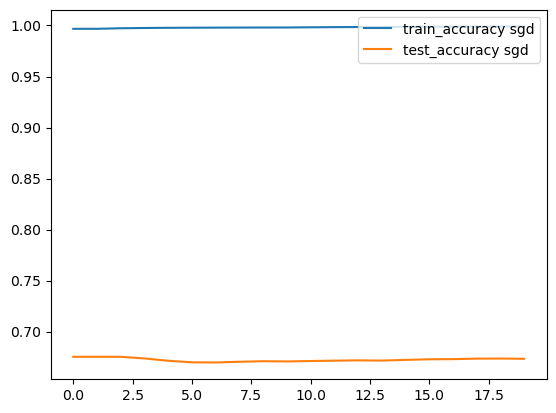

In [43]:
plt.plot(range(epochs), get_smooth(train_accuracies2), label='train_accuracy sgd')
plt.plot(range(epochs), get_smooth(test_accuracies2), label='test_accuracy sgd')
plt.legend(loc='upper right')
print("Accuracy sgd is: ", acc2)

Accuracy rms is:  0.7207792207792207


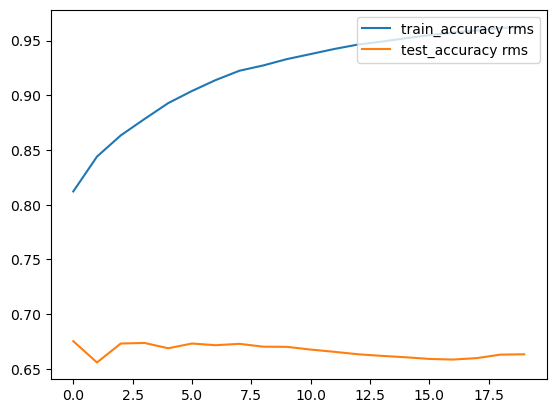

In [44]:
plt.plot(range(epochs), get_smooth(train_accuracies3), label='train_accuracy rms')
plt.plot(range(epochs), get_smooth(test_accuracies3), label='test_accuracy rms')
plt.legend(loc='upper right')
print("Accuracy rms is: ", acc3)